#### importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from scipy.special import inv_boxcox
from sklearn.model_selection import GridSearchCV

#### Reading the Data

In [2]:
df=pd.read_csv('insurance.csv')

In [3]:
df.shape

(1338, 7)

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

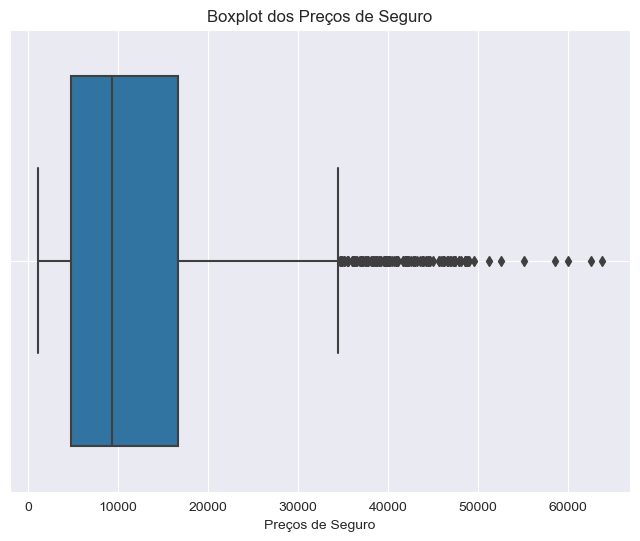

In [8]:
# Criar o Boxplot para os preços de seguro 
plt.figure(figsize=(8,6))
sns.boxplot(x=df['charges'])  # Supondo que 'charges' seja a variável que você quer verificar
plt.title("Boxplot dos Preços de Seguro")
plt.xlabel('Preços de Seguro')
plt.grid(True)
plt.show()


In [9]:
## We can see that there are several outliers on the right side of the boxplot, but we still need to investigate whether these values have to be removed or not.

In [10]:
# Calcular o IQR
Q1 = df['charges'].quantile(0.25)  # Primeiro quartil (25%)
Q3 = df['charges'].quantile(0.75)  # Terceiro quartil (75%)
IQR = Q3 - Q1  # Intervalo interquartil

# Definir os limites para os outliers
lower_bound = Q1 - 1.5 * IQR  # Limite inferior
upper_bound = Q3 + 1.5 * IQR  # Limite superior

# Filtrar os dados removendo os outliers
df_clean = df[(df['charges'] >= lower_bound) & (df['charges'] <= upper_bound)]

# Verificar quantas linhas foram removidas
print(f"Linhas antes da remoção de outliers: {df.shape[0]}")
print(f"Linhas depois da remoção de outliers: {df_clean.shape[0]}")

Linhas antes da remoção de outliers: 1338
Linhas depois da remoção de outliers: 1199


In [11]:
smokers_num = df['smoker'].value_counts()
smokers_num

smoker
no     1064
yes     274
Name: count, dtype: int64

In [12]:
smokers_num = df_clean['smoker'].value_counts()
smokers_num

smoker
no     1061
yes     138
Name: count, dtype: int64

In [13]:
## after removing possible outliers we can notice that basically the only number that decreased was the number of smokers. Therefore, it suggests that those values are not wrongful data, it shows us a fact that smokers pay considerably more money for the insurance than non-smokers do.

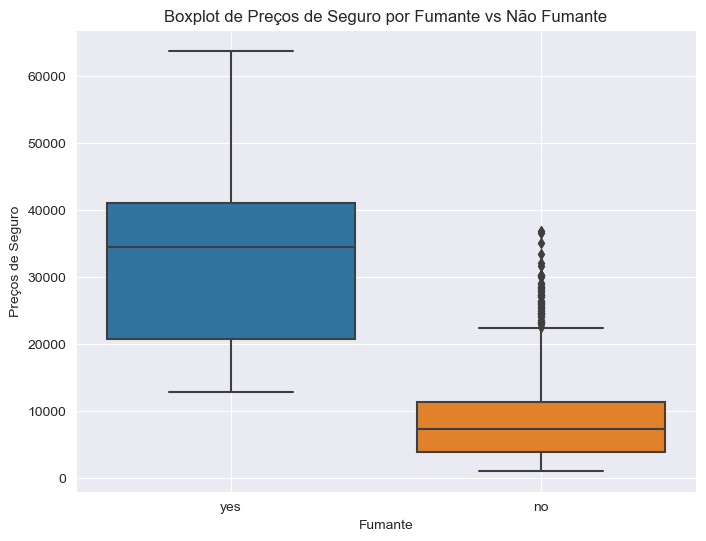

In [14]:
# Boxplot separado por fumantes e não fumantes
plt.figure(figsize=(8,6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Boxplot de Preços de Seguro por Fumante vs Não Fumante')
plt.xlabel('Fumante')
plt.ylabel('Preços de Seguro')
plt.grid(True)
plt.show()


In [15]:
## we can notice that smokers pay considerably more for the insurance than the non-smokers, it reinforces that the "high outliers" are not abnormality in the data but a fact that the dataset shows us.

In [16]:
# Calcular IQR para fumantes e não fumantes separadamente
df_smokers = df[df['smoker'] == 'yes']
df_non_smokers = df[df['smoker'] == 'no']

# IQR para fumantes
Q1_smoker = df_smokers['charges'].quantile(0.25)
Q3_smoker = df_smokers['charges'].quantile(0.75)
IQR_smoker = Q3_smoker - Q1_smoker
lower_bound_smoker = Q1_smoker - 1.5 * IQR_smoker
upper_bound_smoker = Q3_smoker + 1.5 * IQR_smoker

# IQR para não fumantes
Q1_non_smoker = df_non_smokers['charges'].quantile(0.25)
Q3_non_smoker = df_non_smokers['charges'].quantile(0.75)
IQR_non_smoker = Q3_non_smoker - Q1_non_smoker
lower_bound_non_smoker = Q1_non_smoker - 1.5 * IQR_non_smoker
upper_bound_non_smoker = Q3_non_smoker + 1.5 * IQR_non_smoker

print(f"Limites de outliers para fumantes: {lower_bound_smoker} a {upper_bound_smoker}")
print(f"Limites de outliers para não fumantes: {lower_bound_non_smoker} a {upper_bound_non_smoker}")


Limites de outliers para fumantes: -9463.200381249997 a 71308.65186874999
Limites de outliers para não fumantes: -7078.233825 a 22427.559575


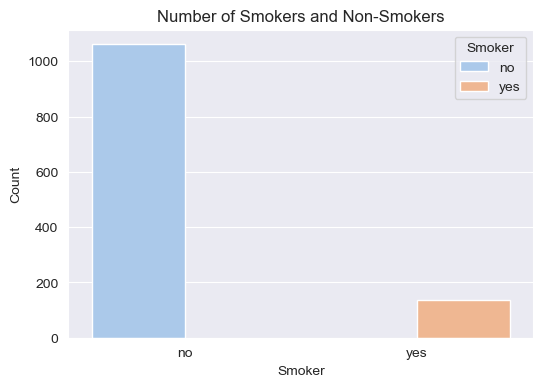

In [17]:
# Plotting the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=smokers_num.index, y=smokers_num.values, hue=smokers_num.index, palette='pastel')
plt.title('Number of Smokers and Non-Smokers')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.legend(title='Smoker')  # Adiciona a legenda
plt.show()

In [18]:
df_region_smokers = df.groupby(['region','smoker']).size().reset_index(name='count')
df_region_smokers

,region,smoker,count
0,northeast,no,257
1,northeast,yes,67
2,northwest,no,267
3,northwest,yes,58
4,southeast,no,273
5,southeast,yes,91
6,southwest,no,267
7,southwest,yes,58


In [19]:
df_total = df.groupby(['region']).size().reset_index(name='count')
df_total

,region,count
0,northeast,324
1,northwest,325
2,southeast,364
3,southwest,325


In [20]:
df_region_smokers = df_region_smokers.merge(df_total, on='region')
df_region_smokers = df_region_smokers[df_region_smokers['smoker'] == 'yes']
df_region_smokers

,region,smoker,count_x,count_y
1,northeast,yes,67,324
3,northwest,yes,58,325
5,southeast,yes,91,364
7,southwest,yes,58,325


In [21]:
df_region_smokers['smoker_percentage'] = (df_region_smokers['count_x'] / df_region_smokers['count_y']) * 100
df_region_smokers

,region,smoker,count_x,count_y,smoker_percentage
1,northeast,yes,67,324,20.679012
3,northwest,yes,58,325,17.846154
5,southeast,yes,91,364,25.000000
7,southwest,yes,58,325,17.846154


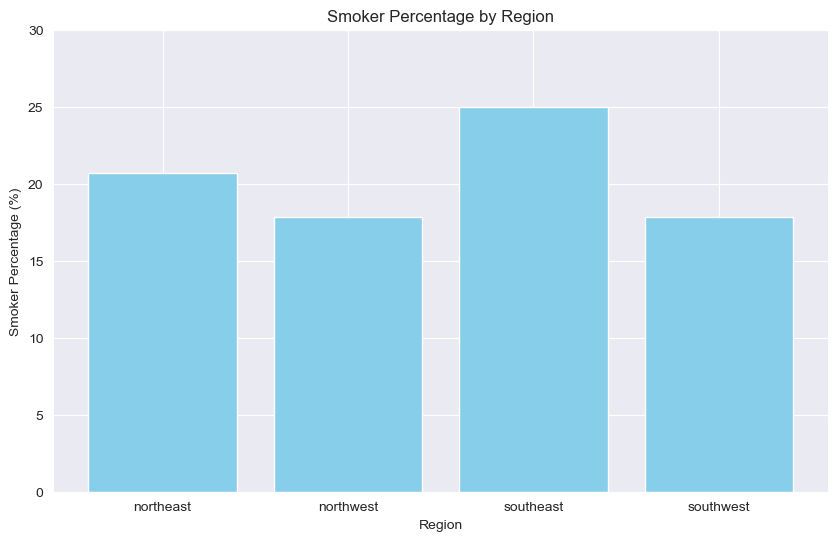

In [22]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_region_smokers['region'], df_region_smokers['smoker_percentage'], color='skyblue')

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Smoker Percentage (%)')
plt.title('Smoker Percentage by Region')
plt.ylim(0, 30)  # Adjust y-axis limits if needed

# Show the plot
plt.show()

In [23]:
df_charges_region = df.groupby('region')['charges'].mean().reset_index()
df_charges_region

,region,charges
0,northeast,13406.384516
1,northwest,12417.575374
2,southeast,14735.411438
3,southwest,12346.937377


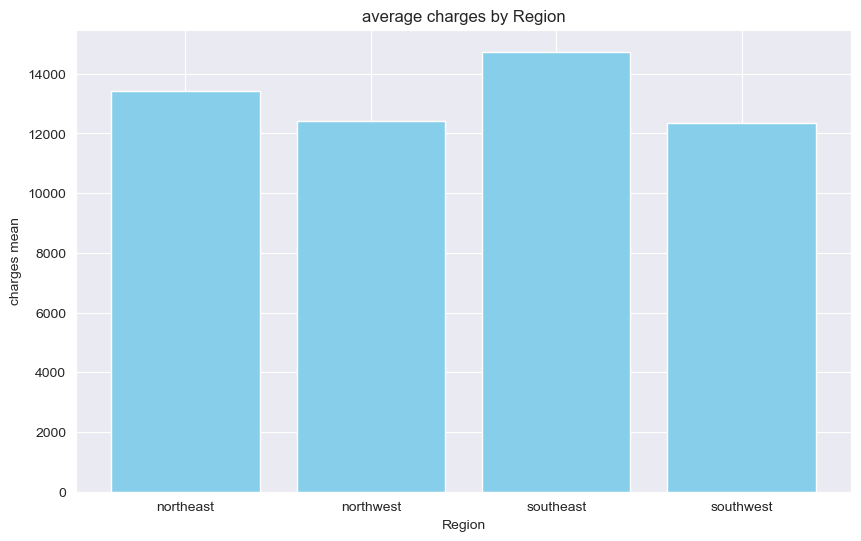

In [24]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_charges_region['region'], df_charges_region['charges'], color='skyblue')

# Add labels and title
plt.xlabel('Region')
plt.ylabel('charges mean')
plt.title('average charges by Region')
  # Adjust y-axis limits if needed

# Show the plot
plt.show()

In [25]:
df_age_region = df.groupby('region')['age'].mean().reset_index()
df_age_region

,region,age
0,northeast,39.268519
1,northwest,39.196923
2,southeast,38.939560
3,southwest,39.455385


In [26]:
df_children_region = df.groupby('region')['children'].mean().reset_index()
df_children_region

,region,children
0,northeast,1.046296
1,northwest,1.147692
2,southeast,1.049451
3,southwest,1.141538


In [27]:
df_bmi_region = df.groupby('region')['bmi'].mean().reset_index()
df_bmi_region

,region,bmi
0,northeast,29.173503
1,northwest,29.199785
2,southeast,33.355989
3,southwest,30.596615


/Users/lucaspadueli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


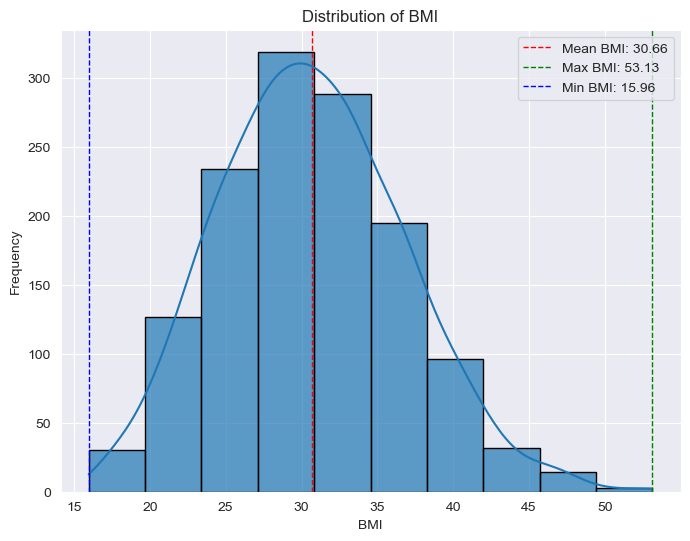

In [28]:
mean_bmi = df['bmi'].mean()
max_bmi = df['bmi'].max()
min_bmi = df['bmi'].min()

# Plotting the distribution of 'bmi' values
plt.figure(figsize=(8, 6))
sns.histplot(df['bmi'], bins=10, kde=True, edgecolor='black', alpha=0.7)
plt.axvline(mean_bmi, color='red', linestyle='dashed', linewidth=1, label=f'Mean BMI: {mean_bmi:.2f}')
plt.axvline(max_bmi, color='green', linestyle='dashed', linewidth=1, label=f'Max BMI: {max_bmi:.2f}')
plt.axvline(min_bmi, color='blue', linestyle='dashed', linewidth=1, label=f'Min BMI: {min_bmi:.2f}')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

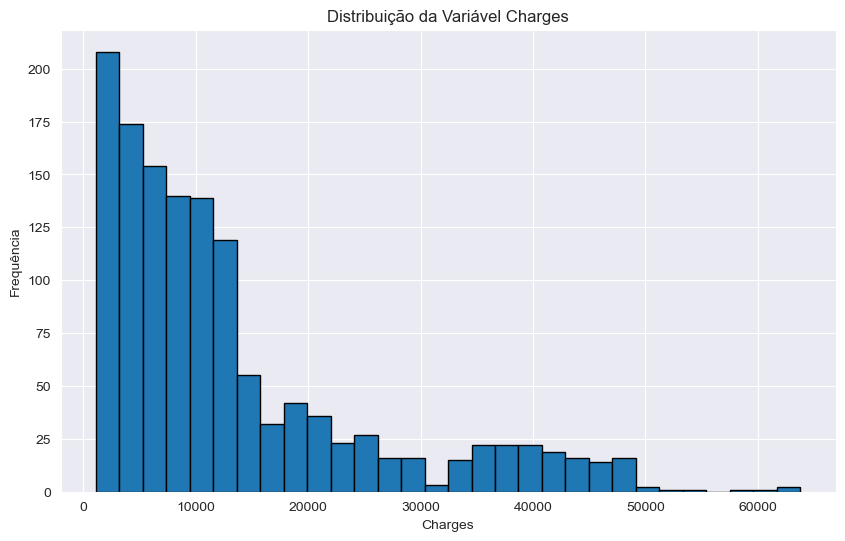

In [29]:
# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(df['charges'], bins=30, edgecolor='black')

# Adicionando título e rótulos
plt.title('Distribuição da Variável Charges')
plt.xlabel('Charges')
plt.ylabel('Frequência')

# Mostrando o gráfico
plt.show()

In [30]:
skewness = skew(df['charges'])
print(f'Skewness: {skewness}')

Skewness: 1.5141797118745743


In [31]:
df['charges_boxcox'], fitted_lambda = boxcox(df['charges'])

print(f"Lambda otimizado: {fitted_lambda}")

Lambda otimizado: 0.043649061187374535


In [32]:
print(fitted_lambda)

0.043649061187374535


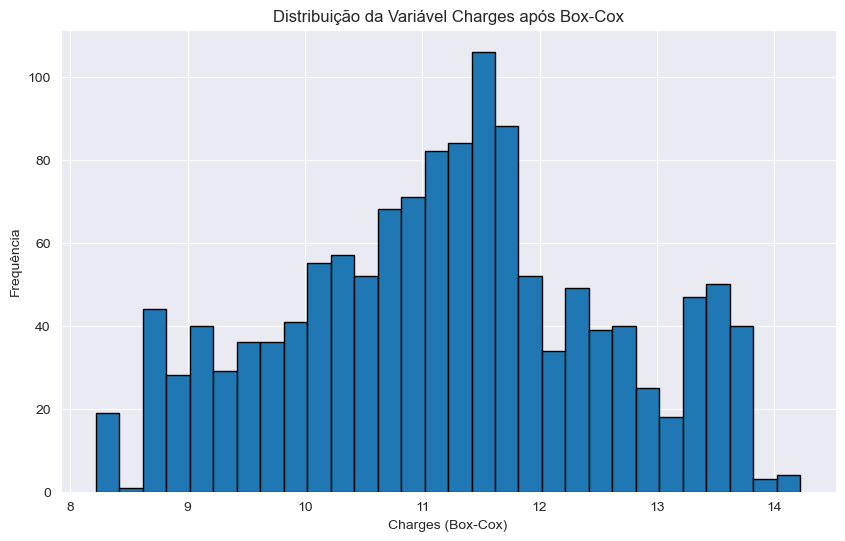

In [33]:

plt.figure(figsize=(10, 6))
plt.hist(df['charges_boxcox'], bins=30, edgecolor='black')
plt.title('Distribuição da Variável Charges após Box-Cox')
plt.xlabel('Charges (Box-Cox)')
plt.ylabel('Frequência')
plt.show()

In [34]:
df_sex_count = df['sex'].value_counts()
df_sex_count

sex
male      676
female    662
Name: count, dtype: int64

In [35]:
df_sex_smoker = df.groupby(['sex','smoker']).size().reset_index(name="count")
df_sex_smoker


,sex,smoker,count
0,female,no,547
1,female,yes,115
2,male,no,517
3,male,yes,159


In [36]:
# Primeiro, calcula o total de pessoas por sexo
total_by_sex = df_sex_smoker.groupby('sex')['count'].sum()

# Agora, cria uma nova coluna 'percentage' com a porcentagem de fumantes por sexo
df_sex_smoker['percentage'] = df_sex_smoker.apply(
    lambda row: (row['count'] / total_by_sex[row['sex']]) * 100, axis=1
)

df_smokers_yes = df_sex_smoker.loc[df_sex_smoker['smoker'] == 'yes']
df_smokers_yes

,sex,smoker,count,percentage
1,female,yes,115,17.371601
3,male,yes,159,23.520710


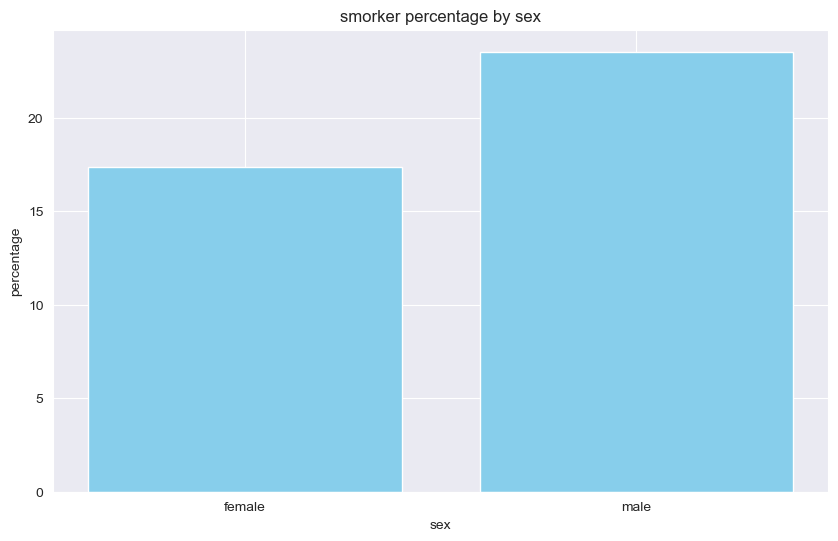

In [37]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_smokers_yes['sex'], df_smokers_yes['percentage'], color='skyblue')

# Add labels and title
plt.xlabel('sex')
plt.ylabel('percentage')
plt.title('smorker percentage by sex')
  # Adjust y-axis limits if needed

# Show the plot
plt.show()

In [38]:
df_sex_charges = df.groupby('sex')['charges'].mean()

In [39]:
df_combined = df_smokers_yes.merge(df_sex_charges, on='sex')
df_combined

,sex,smoker,count,percentage,charges
0,female,yes,115,17.371601,12569.578844
1,male,yes,159,23.520710,13956.751178


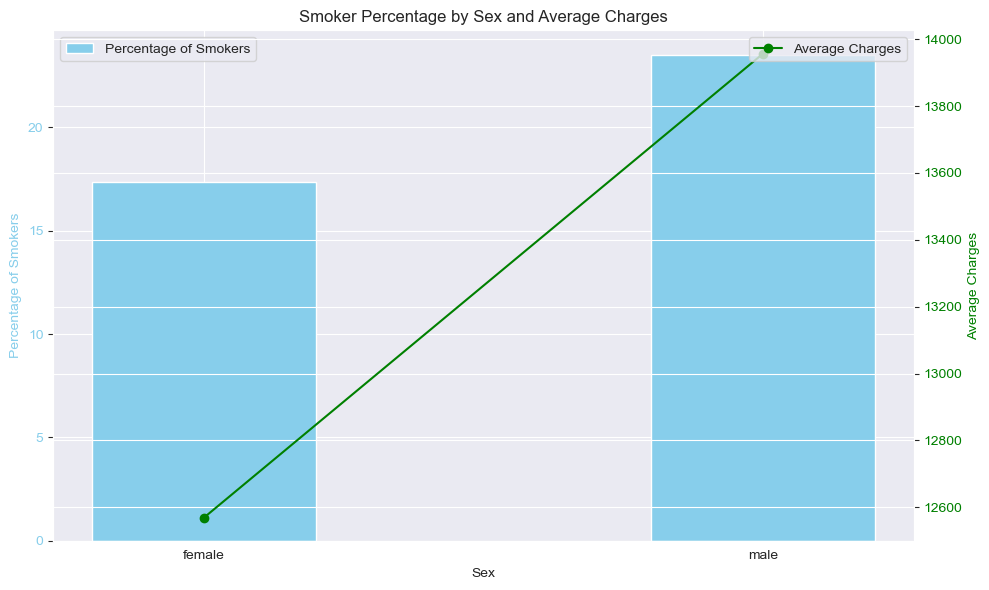

In [40]:
# Definindo o gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Criando a primeira barra (percentagem de fumantes)
ax1.bar(df_combined['sex'], df_combined['percentage'], color='skyblue', width=0.4, label='Percentage of Smokers')

# Eixo Y para o gráfico de barras
ax1.set_xlabel('Sex')
ax1.set_ylabel('Percentage of Smokers', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Criando um segundo eixo Y para o gráfico de linha
ax2 = ax1.twinx()
ax2.plot(df_combined['sex'], df_combined['charges'], color='green', marker='o', label='Average Charges')

# Eixo Y para o gráfico de linha
ax2.set_ylabel('Average Charges', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Título
plt.title('Smoker Percentage by Sex and Average Charges')

# Legendas
fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar o gráfico
plt.show()

In [41]:
df_region_count = df.groupby('region').size().reset_index(name='total_count')
df_region_count

,region,total_count
0,northeast,324
1,northwest,325
2,southeast,364
3,southwest,325


In [42]:
df_sex_region = df.groupby(['sex','region']).size().reset_index(name="male_count")
df_male_region = df_sex_region.loc[df_sex_region['sex'] == 'male']
df_male_region

,sex,region,male_count
4,male,northeast,163
5,male,northwest,161
6,male,southeast,189
7,male,southwest,163


In [43]:
df_merged_male_region = df_male_region.merge(df_region_count, on='region')
df_merged_male_region['male_perc'] = df_merged_male_region['male_count'] / df_merged_male_region['total_count'] * 100
df_merged_male_region

,sex,region,male_count,total_count,male_perc
0,male,northeast,163,324,50.308642
1,male,northwest,161,325,49.538462
2,male,southeast,189,364,51.923077
3,male,southwest,163,325,50.153846


In [44]:
df_bmi_sex = df.groupby('sex')['bmi'].mean()
df_bmi_sex

sex
female    30.377749
male      30.943129
Name: bmi, dtype: float64

In [45]:
df_bmi_region

,region,bmi
0,northeast,29.173503
1,northwest,29.199785
2,southeast,33.355989
3,southwest,30.596615


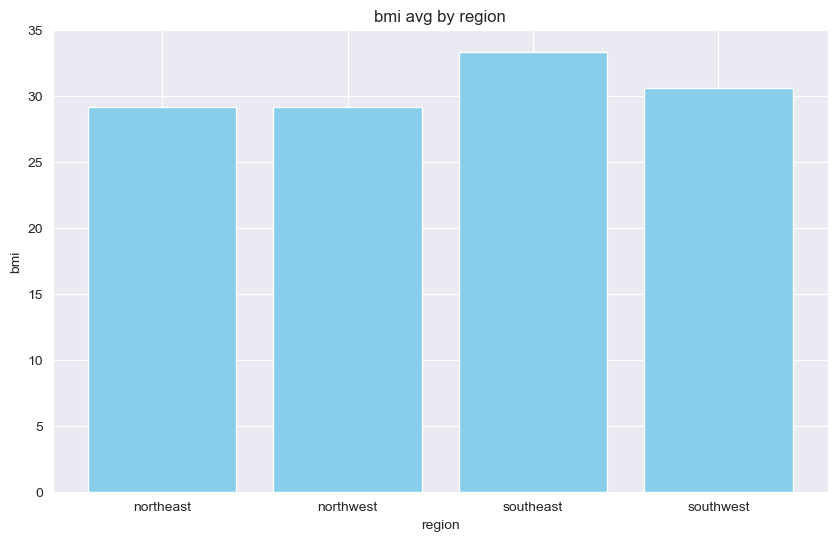

In [46]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_bmi_region['region'], df_bmi_region['bmi'], color='skyblue')

# Add labels and title
plt.xlabel('region')
plt.ylabel('bmi')
plt.title('bmi avg by region')
  # Adjust y-axis limits if needed

# Show the plot
plt.show()

/Users/lucaspadueli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lucaspadueli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lucaspadueli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


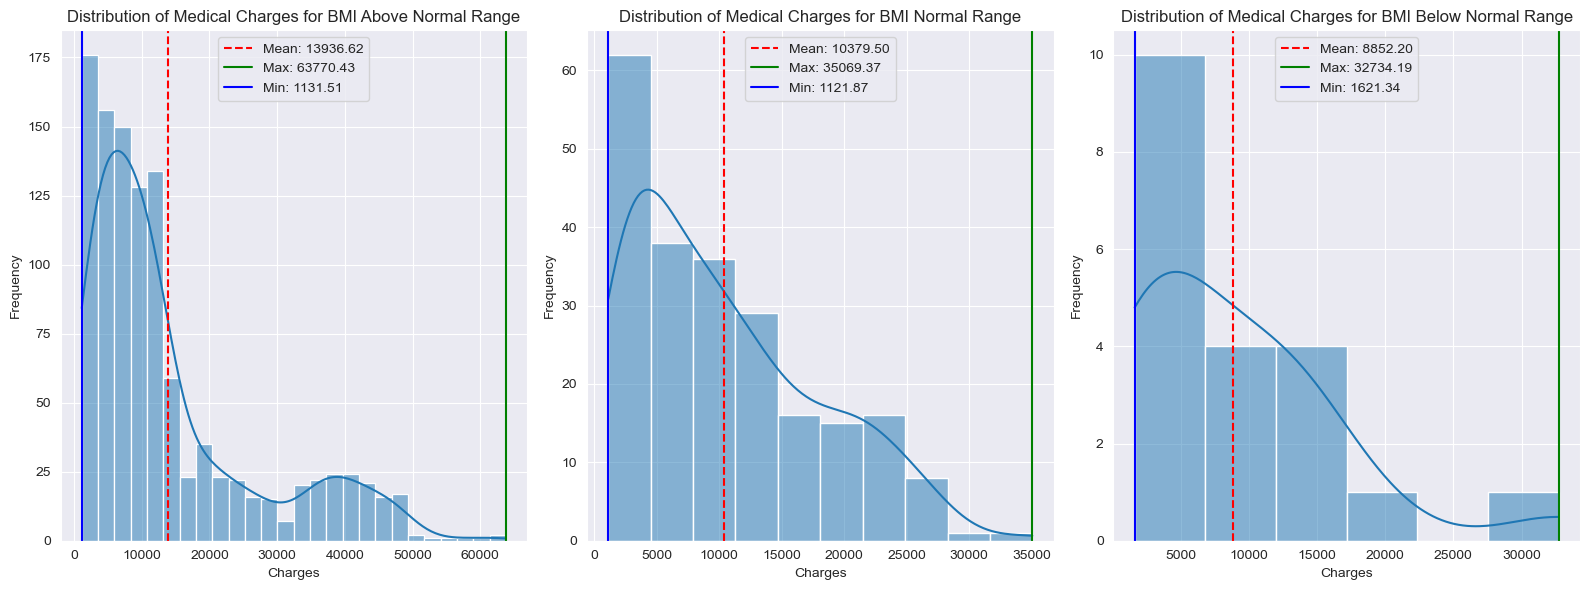

In [47]:
def bmi_category(bmi):
    if bmi > 24.9:
        return 'Above Normal'
    elif bmi >= 18.5 and bmi <= 24.9:
        return 'Normal'
    else:
        return 'Below Normal'

# Apply the function to create a new column 'bmi_category'
df['bmi_category'] = df['bmi'].apply(bmi_category)

# Create subplots for BMI categories
fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # Adjusted figure size

# Plot for individuals with BMI above normal range
above_normal_bmi = df[df['bmi_category'] == 'Above Normal']
sns.histplot(above_normal_bmi['charges'], kde=True, ax=axes[0])
axes[0].axvline(above_normal_bmi['charges'].mean(), color='r', linestyle='--', label=f'Mean: {above_normal_bmi["charges"].mean():.2f}')
axes[0].axvline(above_normal_bmi['charges'].max(), color='g', linestyle='-', label=f'Max: {above_normal_bmi["charges"].max():.2f}')
axes[0].axvline(above_normal_bmi['charges'].min(), color='b', linestyle='-', label=f'Min: {above_normal_bmi["charges"].min():.2f}')
axes[0].set_title('Distribution of Medical Charges for BMI Above Normal Range')
axes[0].set_xlabel('Charges')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot for individuals with normal BMI range
normal_bmi = df[df['bmi_category'] == 'Normal']
sns.histplot(normal_bmi['charges'], kde=True, ax=axes[1])
axes[1].axvline(normal_bmi['charges'].mean(), color='r', linestyle='--', label=f'Mean: {normal_bmi["charges"].mean():.2f}')
axes[1].axvline(normal_bmi['charges'].max(), color='g', linestyle='-', label=f'Max: {normal_bmi["charges"].max():.2f}')
axes[1].axvline(normal_bmi['charges'].min(), color='b', linestyle='-', label=f'Min: {normal_bmi["charges"].min():.2f}')
axes[1].set_title('Distribution of Medical Charges for BMI Normal Range')
axes[1].set_xlabel('Charges')
axes[1].set_ylabel('Frequency')
axes[1].legend()

# Plot for individuals with below normal BMI range
below_normal_bmi = df[df['bmi_category'] == 'Below Normal']
sns.histplot(below_normal_bmi['charges'], kde=True, ax=axes[2])
axes[2].axvline(below_normal_bmi['charges'].mean(), color='r', linestyle='--', label=f'Mean: {below_normal_bmi["charges"].mean():.2f}')
axes[2].axvline(below_normal_bmi['charges'].max(), color='g', linestyle='-', label=f'Max: {below_normal_bmi["charges"].max():.2f}')
axes[2].axvline(below_normal_bmi['charges'].min(), color='b', linestyle='-', label=f'Min: {below_normal_bmi["charges"].min():.2f}')
axes[2].set_title('Distribution of Medical Charges for BMI Below Normal Range')
axes[2].set_xlabel('Charges')
axes[2].set_ylabel('Frequency')
axes[2].legend()

plt.tight_layout()
plt.show()

# Remove the 'bmi_category' column to revert to the original state
df.drop(columns='bmi_category', inplace=True)

In [48]:
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

In [49]:
df_encoded.head()

,age,bmi,children,charges,charges_boxcox,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,12.128980,False,True,False,False,True
1,18,33.770,1,1725.55230,8.808597,True,False,False,True,False
2,28,33.000,3,4449.46200,10.147521,True,False,False,True,False
3,33,22.705,0,21984.47061,12.534951,True,False,True,False,False
4,32,28.880,0,3866.85520,9.945637,True,False,True,False,False


In [50]:
X = df_encoded.drop(['charges_boxcox', 'charges'],axis=1)
y = df_encoded['charges_boxcox']

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
model = LinearRegression()

In [54]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [55]:
y_pred_boxcox = model.predict(X_test_scaled)

In [56]:
y_pred_original = inv_boxcox(y_pred_boxcox, fitted_lambda)

In [57]:
y_pred_original

array([ 9090.31466077,  5670.29861062, 61866.76434465,  9134.74040534,
       14742.95828877,  6082.22541734,  2809.85037914, 15126.22108223,
        3781.48049122, 10528.0201994 , 23156.22857514,  7559.82362416,
        4485.02551743, 48364.17010061, 57331.2794554 , 43920.55986384,
       11659.74415582, 41870.12181956,  7851.08815475, 32024.53675878,
        4880.32768968,  7800.91514075,  2741.3646124 ,  4266.2250878 ,
       11578.51624561, 11435.94044656, 12824.94796817,  5496.75035199,
        9918.38476774,  2603.43548033,  8631.36191206, 11820.54202694,
        3342.83562217,  5239.78329833,  3825.2916588 ,  8720.53475234,
        3276.78306335,  7367.81913087, 44598.55947101, 27109.8964052 ,
        4565.0637943 ,  3628.04995737, 12381.9982931 , 10779.61320281,
        5736.85316899, 11364.15053735,  4273.45349506,  4394.70315778,
       40469.7672228 ,  5564.22529096, 14234.85621712,  2826.60692212,
        8366.89010579,  2816.76265143, 10254.88093317, 11045.46757403,
      

In [58]:
y_test_original = inv_boxcox(y_test, fitted_lambda)

In [59]:
print(y_test_original)

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
           ...     
109     47055.53210
575     12222.89830
535      6067.12675
543     63770.42801
846      9872.70100
Name: charges_boxcox, Length: 268, dtype: float64


In [60]:
y_pred_original_df = pd.DataFrame(y_pred_original, columns=['charges'])

In [61]:
# Converter para DataFrame
y_test_original_df = pd.DataFrame(y_test_original)

# Renomear a coluna para 'charges'
y_test_original_df.columns = ['charges']

# Verificar o DataFrame
y_test_original_df.head()

,charges
764,9095.06825
887,5272.17580
890,29330.98315
1293,9301.89355
259,33750.29180


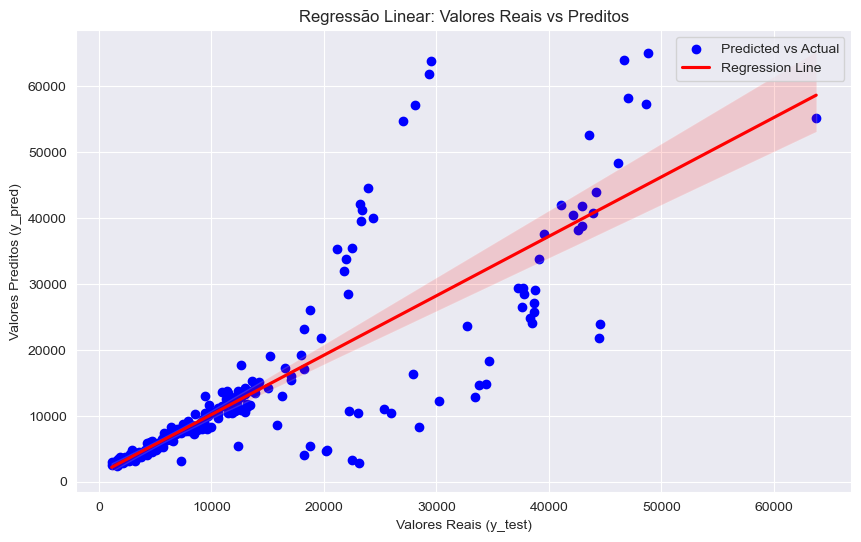

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(y_test_original_df['charges'], y_pred_original_df['charges'], color='blue', label='Predicted vs Actual')
sns.regplot(x=y_test_original_df['charges'], y=y_pred_original_df['charges'], scatter=False, color='red', label='Regression Line')
plt.xlabel('Valores Reais (y_test)')
plt.ylabel('Valores Preditos (y_pred)')
plt.title('Regressão Linear: Valores Reais vs Preditos')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test_original_df, y_pred_original_df)
r2

0.6537283612806422

In [64]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred_original_df,y_test_original_df)
mse

53758232.66275797

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Instanciar o modelo
model = LinearRegression()

# Aplicar o cross-validation com 5 folds (5 partes)
# Usando o R² como métrica
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Imprimir os resultados
print("R² scores para cada fold:", scores)
print("R² score médio:", scores.mean())


R² scores para cada fold: [0.80104872 0.68971077 0.8331375  0.76993398 0.74014246]
R² score médio: 0.7667946857773631


In [66]:
mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
# Mostrar os resultados
print("MSE negativo para cada fold:", mse_scores)
print("MSE médio (positivo):", -mse_scores.mean())

MSE negativo para cada fold: [-0.39937307 -0.57174177 -0.30185394 -0.42952957 -0.4684946 ]
MSE médio (positivo): 0.4341985911778877


In [67]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

estimator = Pipeline([
    ("polynomial_features", PolynomialFeatures()),
    ("scaler", StandardScaler()),
    ("ridge_regression",Ridge())
])

params = {
    'polynomial_features__degree':[1,2,3,4,5,6],
    'ridge_regression__alpha': np.geomspace(4,20,30)
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator,params,cv=kf)

In [68]:
grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [1, 2, 3, 4, 5, 6],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [69]:
grid.best_params_

{'polynomial_features__degree': 2, 'ridge_regression__alpha': 4.0}

In [70]:
y_pred_grid = grid.predict(X_test)

In [71]:
r2_score(y_test,y_pred_grid)

0.8639078614298312

In [72]:
y_pred_grid_reversed = inv_boxcox(y_pred_grid, fitted_lambda)
y_test_reversed = inv_boxcox(y_test, fitted_lambda)

In [73]:
# Converter y_pred_grid_reversed para DataFrame
y_pred_grid_df = pd.DataFrame(y_pred_grid_reversed, columns=['charges_pred'])

In [74]:
y_test_reversed_df = pd.DataFrame(y_test_reversed).reset_index(drop=True)
y_test_reversed_df.columns = ['charges_test']

In [75]:
# Calcular o MSE
mse_value = mean_squared_error(y_test_reversed_df, y_pred_grid_reversed)

# Calcular o RMSE (raiz quadrada do MSE)
rmse_value = np.sqrt(mse_value)

print(f"MSE: {mse_value}")
print(f"RMSE: {rmse_value}")

MSE: 22170360.48433454
RMSE: 4708.541226785058


In [76]:
r2_score(y_test_reversed_df, y_pred_grid_reversed)

0.8571945788458224

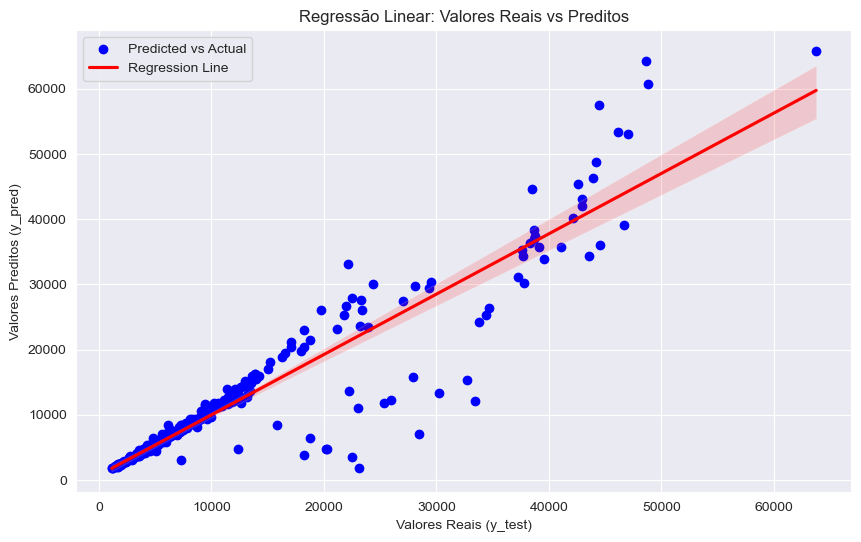

In [77]:
# Plotar os resultados
plt.figure(figsize=(10,6))

# Scatter plot dos valores reais e preditos
plt.scatter(y_test_reversed_df['charges_test'], y_pred_grid_df['charges_pred'], color='blue', label='Predicted vs Actual')

# Adicionar a linha de regressão
sns.regplot(x=y_test_reversed_df['charges_test'], y=y_pred_grid_df['charges_pred'], scatter=False, color='red', label='Regression Line')

# Configurações do gráfico
plt.xlabel('Valores Reais (y_test)')
plt.ylabel('Valores Preditos (y_pred)')
plt.title('Regressão Linear: Valores Reais vs Preditos')
plt.legend()
plt.show()

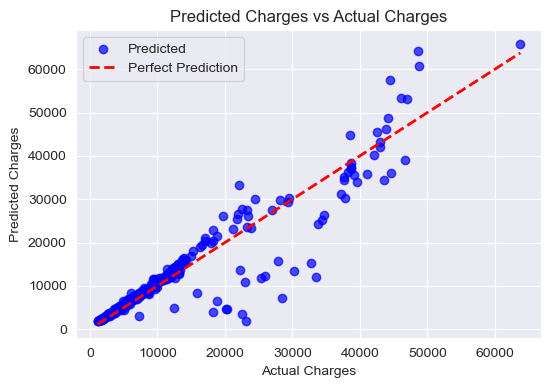

In [78]:
plt.figure(figsize=(6, 4))

# Scatter plot dos valores preditos vs valores reais
plt.scatter(y_test_reversed_df['charges_test'], y_pred_grid_df['charges_pred'], color='blue', alpha=0.7, label='Predicted')

# Linha de referência para a "predição perfeita"
plt.plot([y_test_reversed_df['charges_test'].min(), y_test_reversed_df['charges_test'].max()],
         [y_test_reversed_df['charges_test'].min(), y_test_reversed_df['charges_test'].max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

# Configurações do gráfico
plt.title('Predicted Charges vs Actual Charges')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.legend()
plt.grid(True)
plt.show()


In [79]:
# Criar um DataFrame com valores reais e preditos lado a lado
comparison_df = pd.DataFrame({
    'Actual Charges': y_test_reversed_df['charges_test'],
    'Predicted Charges': y_pred_grid_df['charges_pred'],
    'Difference': y_test_reversed_df['charges_test'] - y_pred_grid_df['charges_pred']  # Diferença entre real e predito
})

# Exibir as primeiras linhas da tabela
comparison_df.head()

,Actual Charges,Predicted Charges,Difference
0,9095.06825,10533.648464,-1438.580214
1,5272.17580,5453.835261,-181.659461
2,29330.98315,29418.335964,-87.352814
3,9301.89355,10556.201671,-1254.308121
4,33750.29180,24196.832090,9553.459710


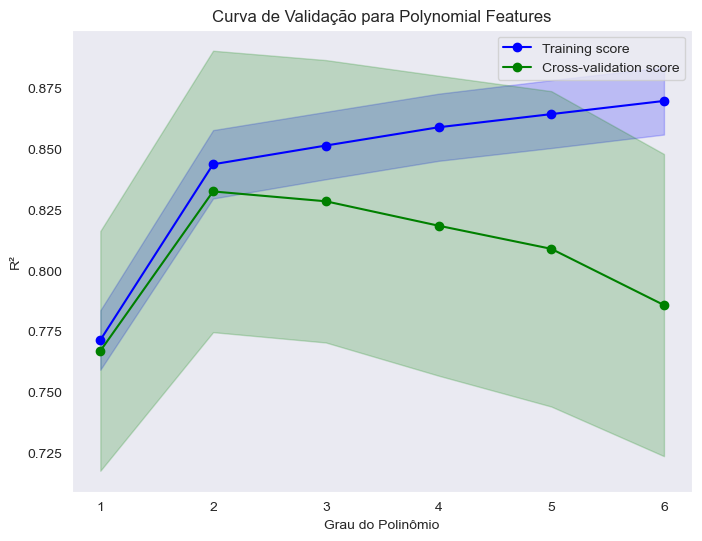

In [80]:
from sklearn.model_selection import validation_curve

# Definir os graus polinomiais a serem testados
param_range = [1, 2, 3, 4, 5, 6]

# Obter a curva de validação para Ridge Regression com Polynomial Features
train_scores, test_scores = validation_curve(
    estimator,
    X, y,
    param_name="polynomial_features__degree",
    param_range=param_range,
    cv=5,
    scoring="r2"
)

# Calcular a média e o desvio padrão das pontuações
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotar a curva de validação
plt.figure(figsize=(8,6))
plt.plot(param_range, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(param_range, test_mean, label="Cross-validation score", color="green", marker="o")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="green", alpha=0.2)

plt.title("Curva de Validação para Polynomial Features")
plt.xlabel("Grau do Polinômio")
plt.ylabel("R²")
plt.legend(loc="best")
plt.grid()
plt.show()


/Users/lucaspadueli/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


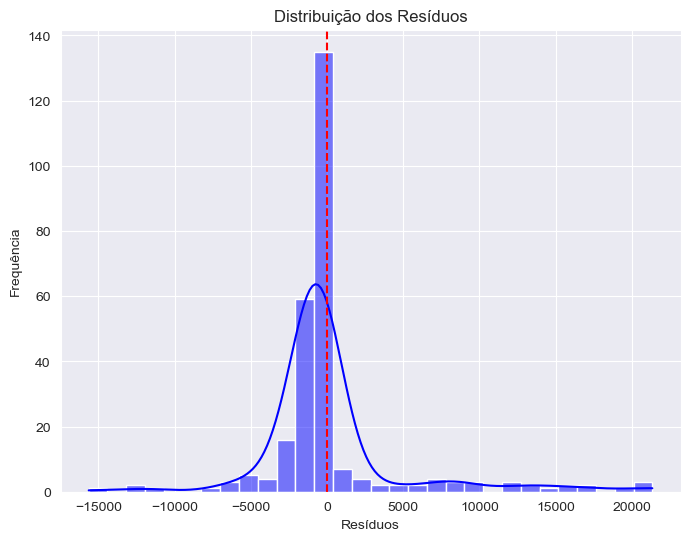

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular os resíduos
residuals = y_test_reversed_df['charges_test'] - y_pred_grid_df['charges_pred']

# Plotar a distribuição dos resíduos (Histograma)
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True, color='blue')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()


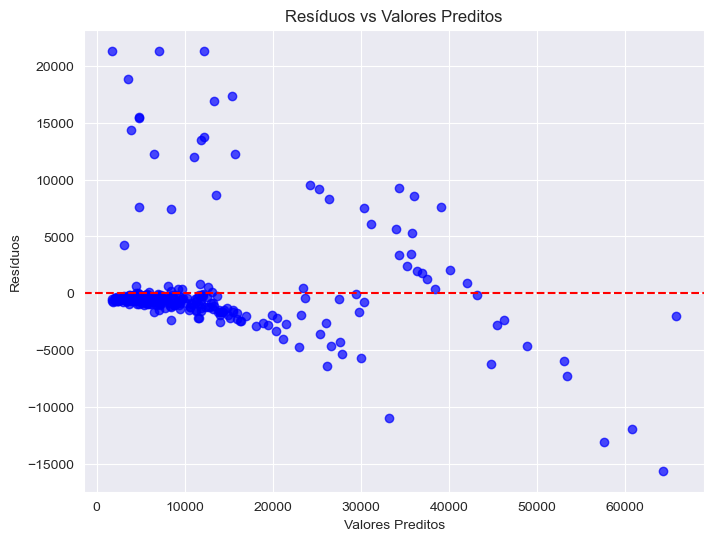

In [82]:
# Plotar resíduos vs valores preditos
plt.figure(figsize=(8,6))
plt.scatter(y_pred_grid_df['charges_pred'], residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Preditos')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.grid(True)
plt.show()


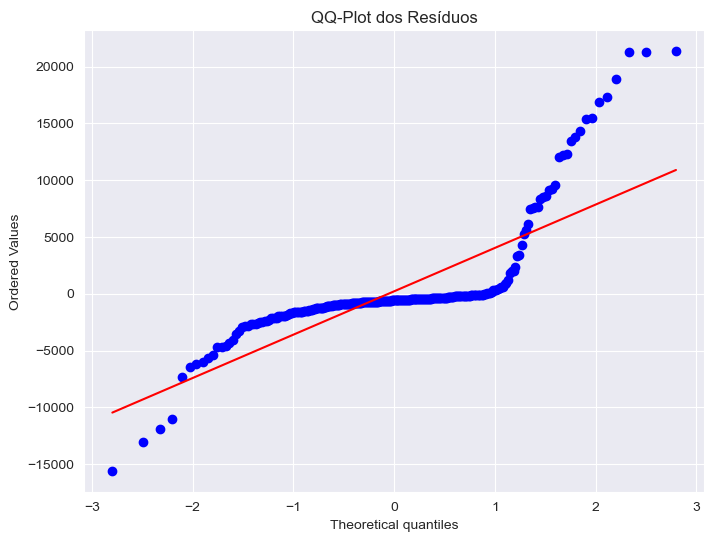

In [83]:
import scipy.stats as stats

# QQ-Plot dos resíduos
plt.figure(figsize=(8,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-Plot dos Resíduos')
plt.grid(True)
plt.show()
